In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
%load_ext autoreload
%autoreload 2

In [2]:
plt.style.use('niceplot2')

## Power law mass function sampling

In [3]:
def pl_generate_number(alpha, x_min, x_max, N):
    """
    Generate N random samples with a power-law distribution of given slope alpha, x_min, and x_max
    """
    if (alpha==1):
        raise ValueError("We currently don't support power-law with slope 1")
                
    if (x_max<=x_min):
        raise ValueError("x_max must be larger than x_min")
        
    r = np.random.uniform(0,1,N)
    return ( (x_max**(1.+alpha) - x_min**(1.+alpha)) * r + x_min**(1.+alpha) ) ** (1./(1.+alpha))

def pl_generate_sum(alpha, x_min, x_max, sumPL, oversample=1.1):
    """
    Generate a sample with a power-law distribution of given slope alpha, x_min, x_max with a given sumPL
    """
    if (alpha==1):
        raise ValueError("We currently don't support power-law with slope 1")
        
    if (x_max<=x_min):
        raise ValueError("x_max must be larger than x_min")
        
    x_ave = np.log(x_max/x_min)/(1./x_min-1./x_max)
    
    N_init = int(sumPL * oversample / x_ave)
    r = np.random.uniform(0,1,N_init)
    pl_init = ( (x_max**(1.+alpha) - x_min**(1.+alpha)) * r + x_min**(1.+alpha) ) ** (1./(1.+alpha))
    
    return pl_init[np.cumsum(pl_init)<sumPL]

## Sample GC masses

In [4]:
mStarTot = 5e10
fGC = 0.012
mGCs = pl_generate_sum(-2., 1e4, 1e7, mStarTot*fGC)

In [5]:
import scipy.special as special
import scipy.integrate as integrate

## Define spherical Sersic profile $\rho(R) = A\exp{(-2n_s(R/R_e)^{1/n_s})}$
## The total mass is the integration between 0  to infinity: $M_{\rm tot} = \int_0^{\infty}4\pi r^2\rho(r)dr=\frac{4\pi A}{8^{n_s}}n_s^{1-3n_s}R_e^3\Gamma(3n_s)$

In [6]:
def rho_star(R, A, Re, ns):
    return A * np.exp( -2 * ns * (R/Re)**(1./ns) )

def mstar_tot(A,Re,ns):
    return 4*np.pi*A/8**ns * ns**(1-3*ns) * Re**3 * special.gamma(3*ns)

In [7]:
# find normalization factor A by giving total stellar mass
Re = 4
ns = 2.2
A = 5e10/mstar_tot(1, 4, 2.2)

In [8]:
from scipy.interpolate import interp1d

# digitize cumulative mass profile
nGrid = 10000
rGrid = np.logspace(-3,2.5,nGrid)
mRGrid = np.zeros(nGrid)
for i in range(nGrid):
    r = rGrid[i]
    mRGrid[i] = integrate.quad(lambda R: rho_star(R, A, Re, ns)*4*np.pi*R*R, 0, r)[0]

fGC = 0.012
radius_from_mass = interp1d(mRGrid*fGC, rGrid)

In [9]:
# map the cumulative mass of GC samples to the sample radius
mGCcum = np.cumsum(mGCs)
rGCs = radius_from_mass(mGCcum)

## return mGCs and rGCs

In [10]:
print mGCs
print rGCs

[ 13405.39639868  18422.88983929  10101.08999504 ...,  14906.7793698
  36893.20244445  17630.44222902]
[  6.95637153e-02   9.57406488e-02   1.06117885e-01 ...,   1.19917379e+02
   1.37510075e+02   1.69634537e+02]


## some plots

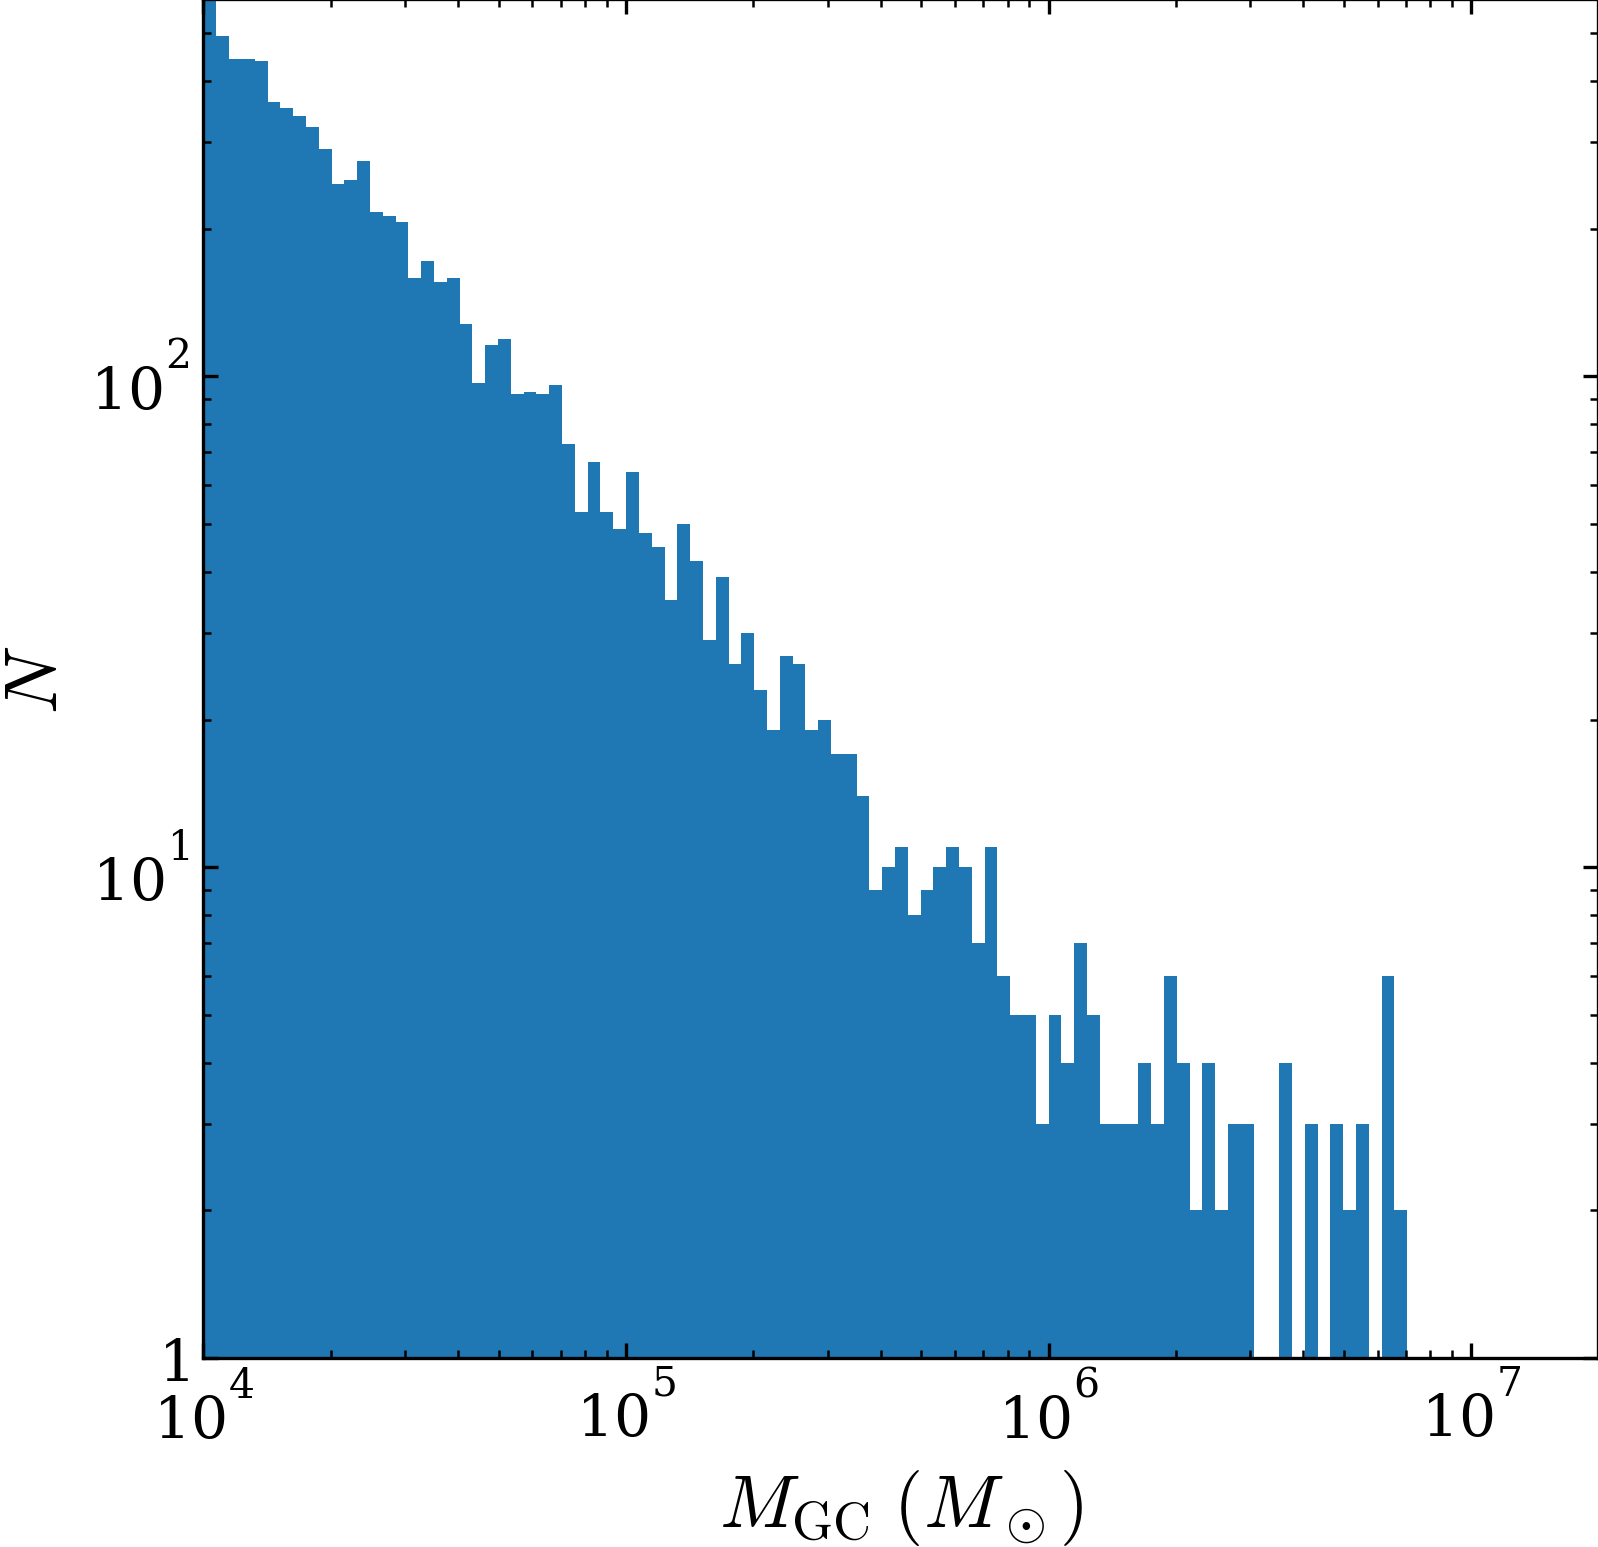

In [11]:
plt.hist(mGCs, np.logspace(4,7,100))
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e4,2e7)

plt.xlabel(r'$M_{\rm GC} \; (M_\odot)$')
plt.ylabel(r'$N$')
plt.show()

Text(0,0.5,'$\\rm GC \\; density \\; (kpc^{-3})$')

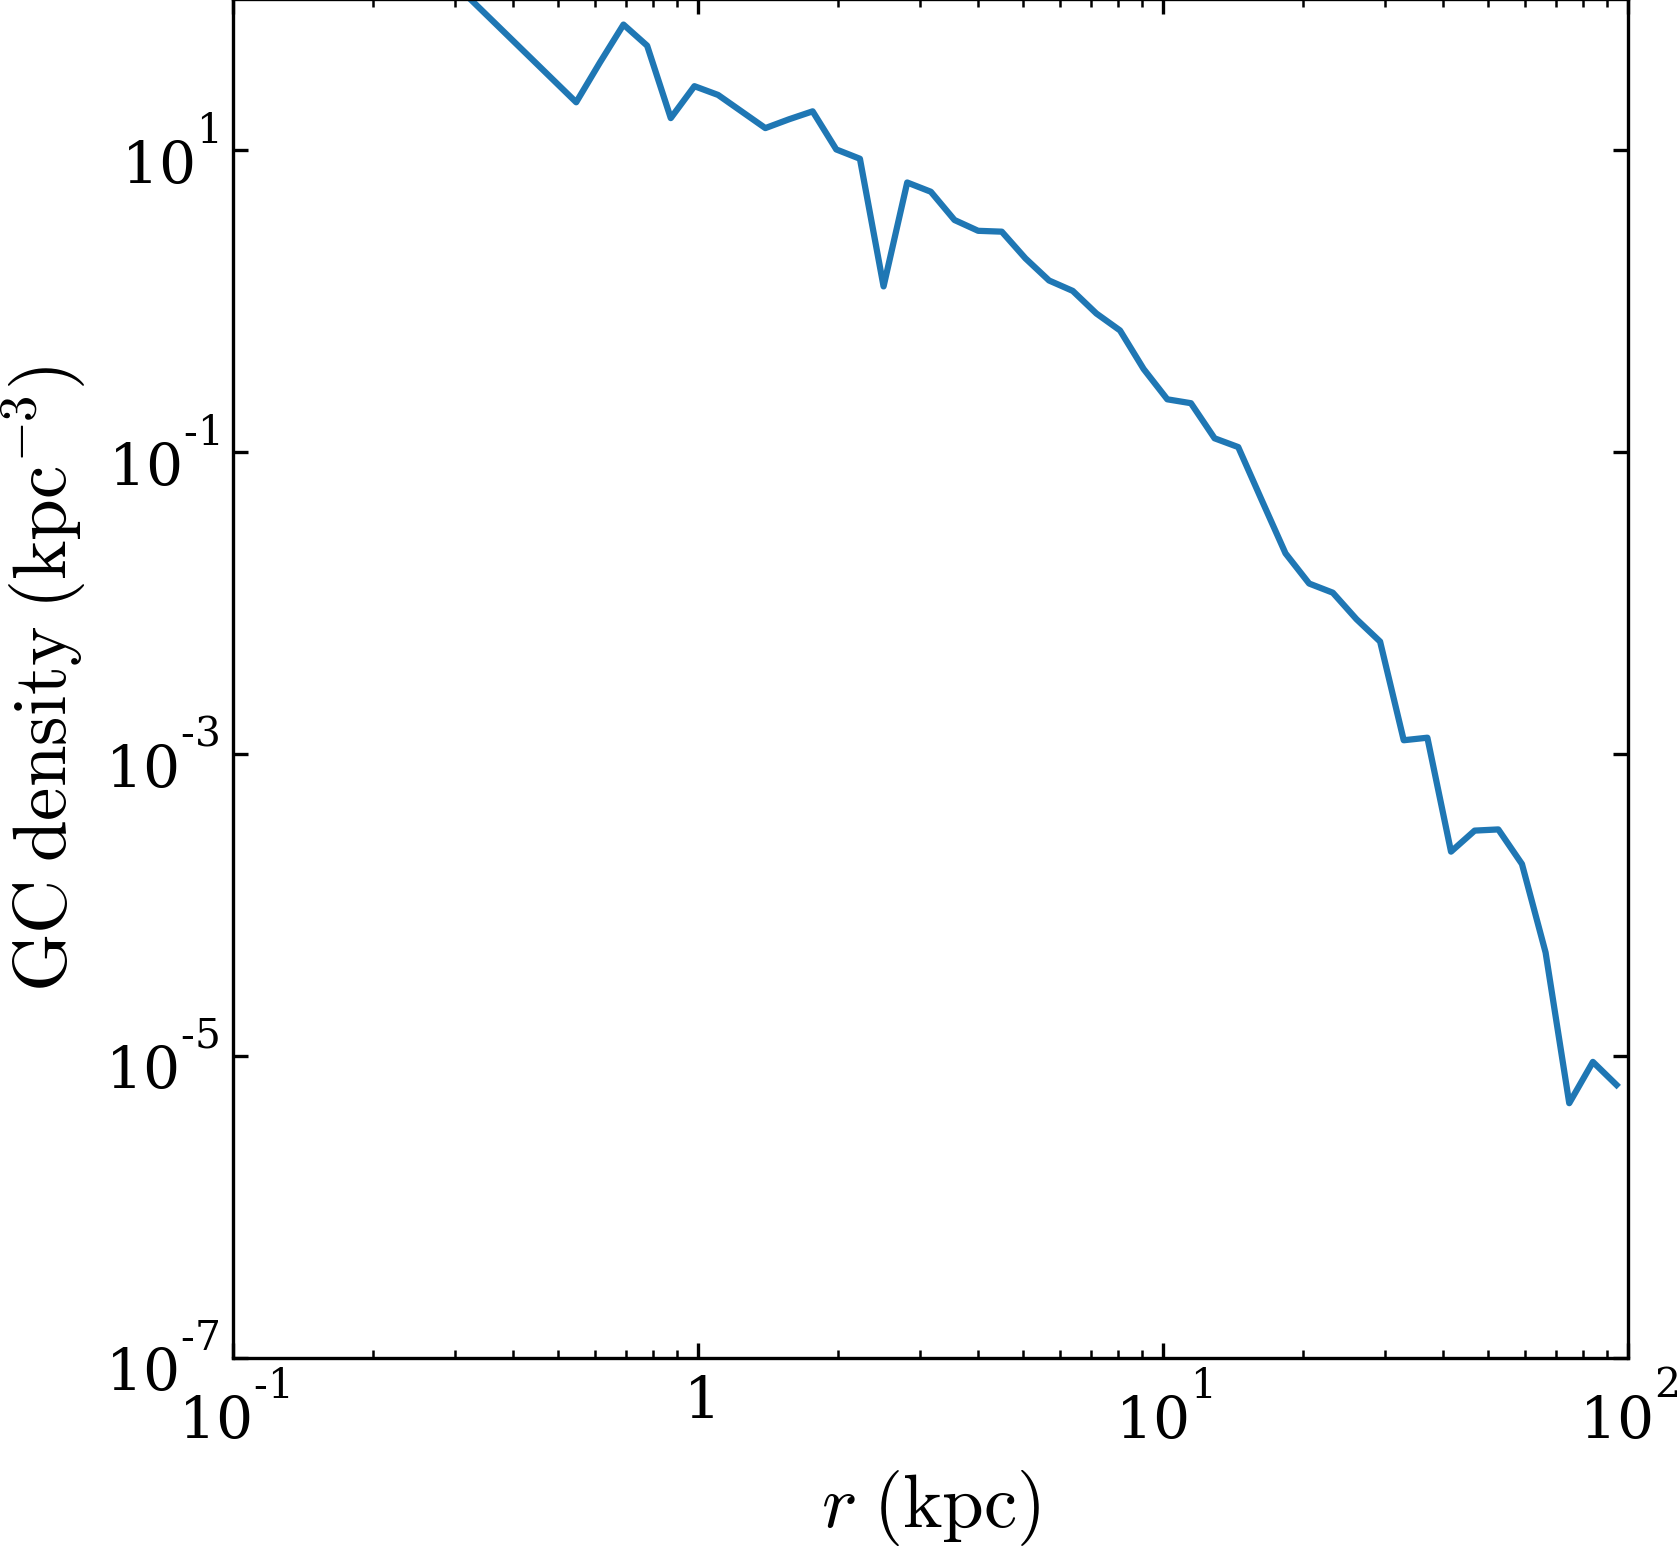

In [12]:
hist, bins = np.histogram(rGCs, np.logspace(-1,2,60))
binPlot = np.sqrt(bins[1:]*bins[:-1])
volumes = 4*np.pi/3.*(bins[1:]**3-bins[:-1]**3)
plt.plot(binPlot[hist!=0], hist[hist!=0]/volumes[hist!=0])
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1,100)
plt.ylim(1e-7,100)

plt.xlabel(r'$r \; (\rm kpc)$')
plt.ylabel(r'$\rm GC \; density \; (kpc^{-3})$')

Text(0,0.5,'$M_{\\rm GC}(<r)\\;(M_\\odot)$')

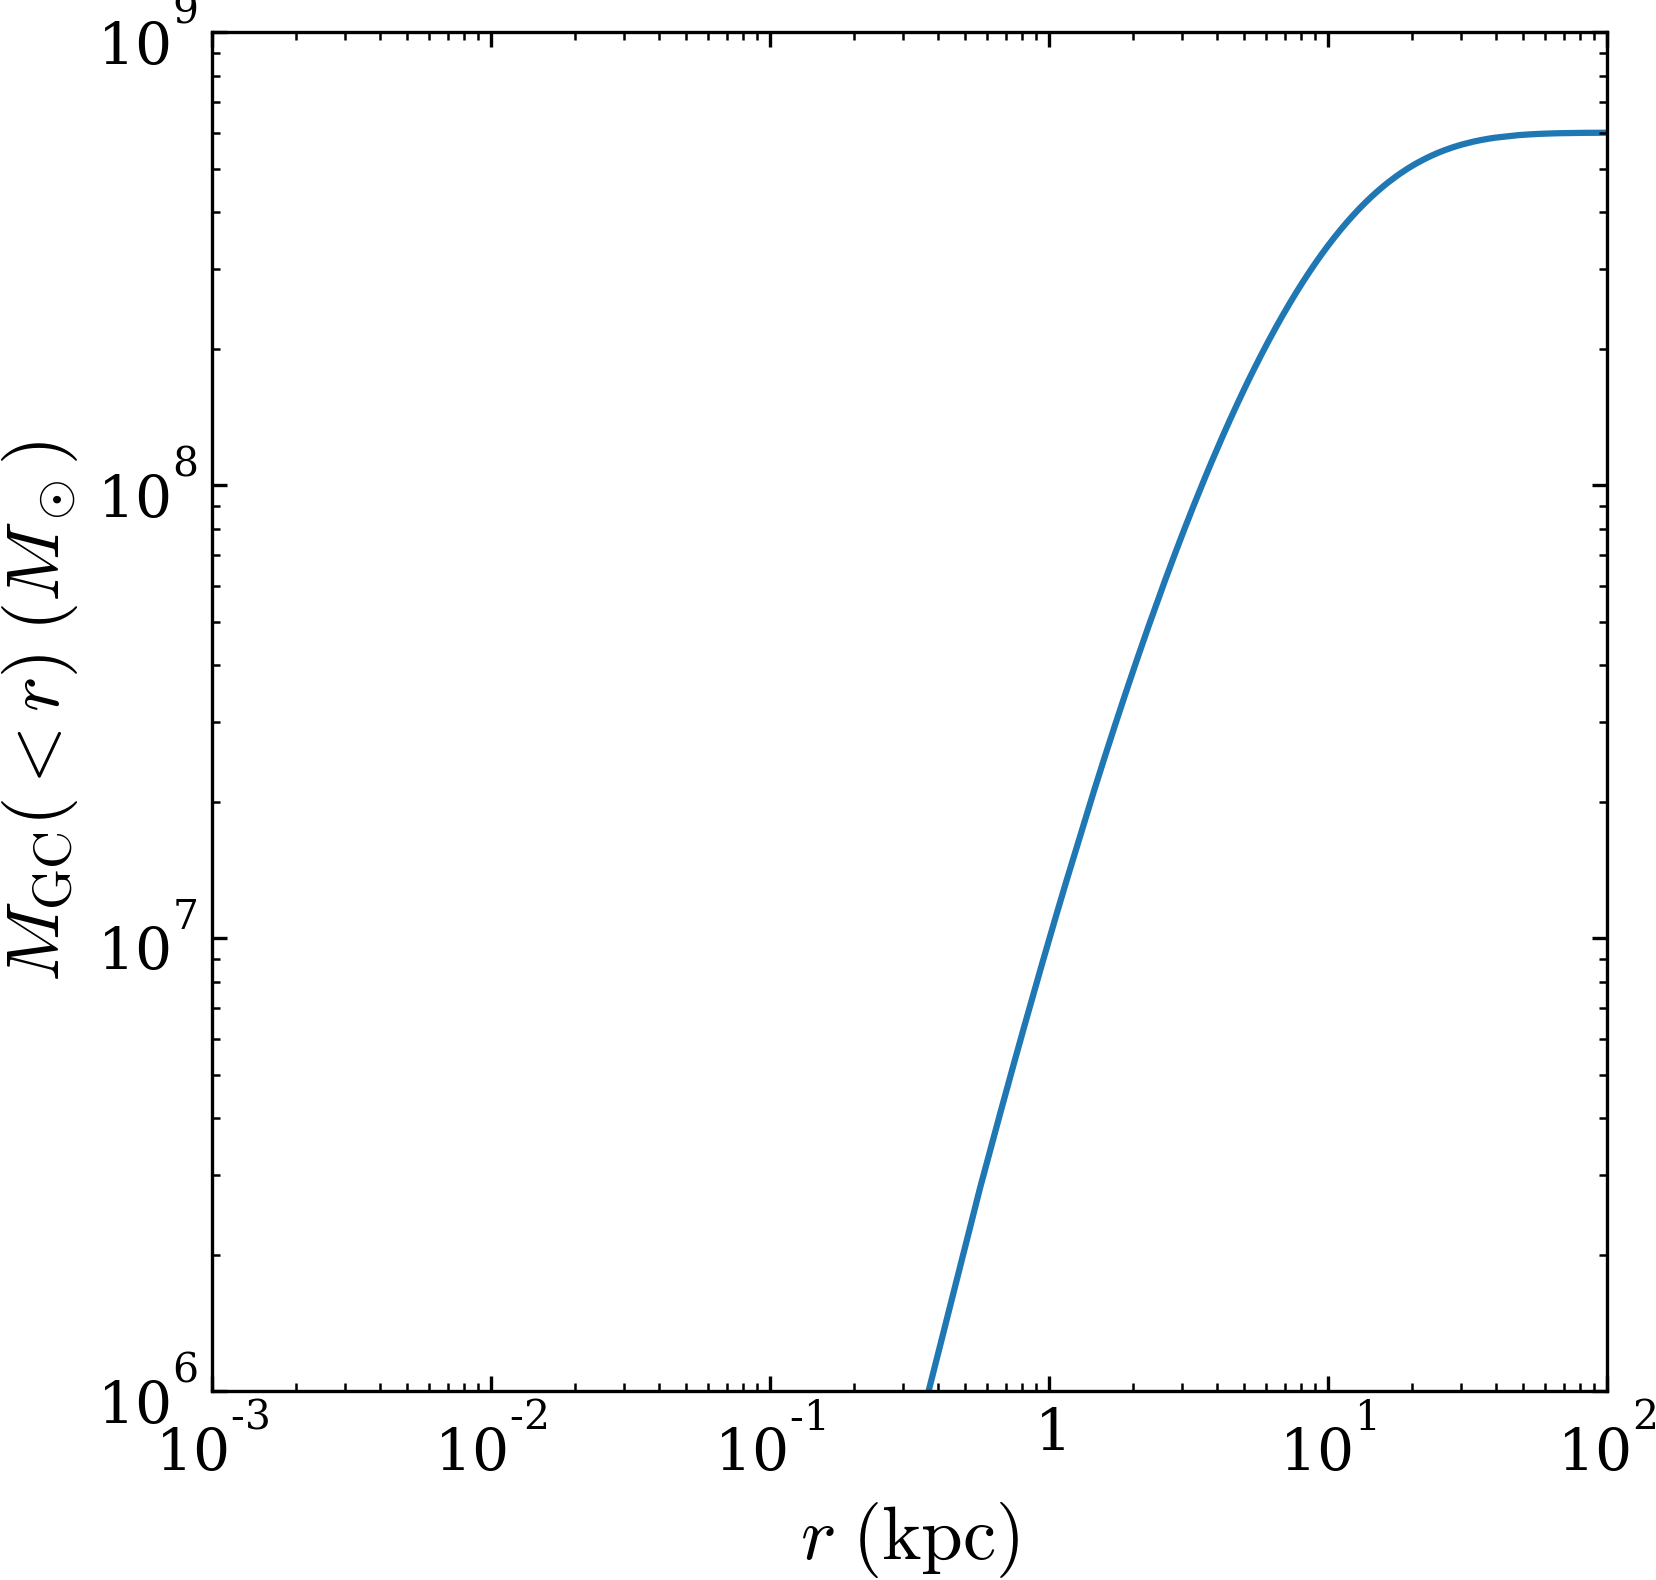

In [13]:
plt.plot(rGCs, mGCcum)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3, 100)
plt.ylim(1e6,1e9)

plt.xlabel(r'$r \; (\rm kpc)$')
plt.ylabel(r'$M_{\rm GC}(<r)\;(M_\odot)$')